In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import numba

Useful functions:

In [2]:
def rebuild_tree(tree):
    out_tree = dict()
    for node in tree:
        out_tree[node[1]] = out_tree.get(node[1], {}) | {node[0]: node[2]}
    return out_tree

In [3]:
@numba.njit
def mutation_prob(base_a, base_b, alfa, t):
    if base_a == base_b:
        return (1+3*np.exp((-4*alfa*t)/3))/4
    else:
        return (1-np.exp((-4*alfa*t)/3))/4

Tree preparation:

In [4]:
tree = []

with open("tree.txt", "r") as f:
    for line in f.readlines():
        l = line.strip().split(" ")
        l[2] = float(l[2])
        tree.append(l)

tree = rebuild_tree(tree)

leaf_bases = {"Human": "A",
             "Chimp": "A",
             "Baboon": "A",
             "Macaque": "A",
             "Marmoset": "A",
             "Rabbit": "A",
             "Rat": "A",
             "Mouse": "A",
             "Cow": "A",
             "Pig": "A",
             "Horse": "A",
             "Cat": "A",
             "Dog": "A",
             "Elephant": "A"}

Leaf sequence:

In [5]:
leaf_sequences = dict()

with open("cftr.txt", "r") as f:
    leaf_name = ""
    for line in f.readlines():
        if line[0] == ">":
            leaf_name = line[1:].strip()
        else:
            leaf_sequences[leaf_name] = leaf_sequences.get(leaf_name, "") + line.strip()

Exons positions:

In [6]:
exons_pos = []

with open("exons.txt", "r") as f:
    for line in f.readlines():
        if line != "":
            ranges = line.strip().split(" ")
            exons_pos.append([int(ranges[0]), int(ranges[1])])

In [7]:
bases = ["A", "C", "G", "T"]

In [8]:
test_tree = [["B", "A", 0.02],
             ["C", "A", 0.03],
             ["D", "B", 0.01],
             ["E", "B", 0.02],
             ["F", "C", 0.05]]
test_bases = {"D": "A", "E": "C", "F": "A"}

              A
        0.02/   \
           /     \0.03
          B      C
    0.01/  \      \0.05
       /    \0.02  \
      D     E      F

a)

Computation for one column:

In [9]:
def falsenstein_one_col(root, tree, alfa, leaf_bases, poz):
    sol_table = dict()
    total_p = 0
    nodes = tree.keys()
    def tree_prob(root, base):
        sol = sol_table.get((root, base), None)
        if sol is not None:
            return sol
        if root not in nodes:
            leaf_val = leaf_bases[root][poz]
            if leaf_val == 'N' or leaf_val == '-':
                return 1
            elif base == leaf_val:
                return 1
            else:
                return 0
        else:
            childrens = tree[root]
            total = 1
            for child, time in childrens.items():
                temp = 0
                for child_base in bases:
                    temp += (tree_prob(child, child_base)
                             *mutation_prob(base, child_base, alfa, time))
                total *= temp
            sol_table[(root, base)] = total
            return total

    for base in bases:
        total_p += tree_prob(root, base)
    return total_p/4

Computation for whole alignment:

In [10]:
def falsenstein_all_col(root, tree, alfa, leaf_bases, start, length):
    total_log_p = 0
    #k = len(list(leaf_bases.values())[0])
    for i in range(start, start+length, 1):
        col_prob = falsenstein_one_col(root, tree, alfa, leaf_bases, i)
        if col_prob == 0:
            total_log_p -= float("inf")
        else:
            total_log_p += np.log(col_prob)
    return np.exp(total_log_p)

b)

In [11]:
print("All same bases in leaves and mutation prob. 0.2: {}".format(falsenstein_one_col("Root", tree, 0.2, leaf_bases, 0 )))
print("All same bases in leaves and mutation prob. 1.0: {}".format(falsenstein_one_col("Root", tree, 1, leaf_bases, 0)))

All same bases in leaves and mutation prob. 0.2: 0.18337011879050813
All same bases in leaves and mutation prob. 1.0: 0.054454067155337384


c)

In [12]:
def opt_mut_speed(root, tree, leaf_bases, start, length):
    test_alfa = 0.1
    best_alfa = 0.1
    best_log_prob = -float("inf")
    for i in range(20):
        test_prob = falsenstein_all_col(root, tree, test_alfa, leaf_bases, start, length)
        if test_prob == 0:
            test_log_prob = -float("inf")
        else:
            test_log_prob = np.log(test_prob)

        if test_log_prob > best_log_prob:
            best_alfa = test_alfa
            best_log_prob = test_log_prob
        test_alfa =round(test_alfa+0.1,1)
    return best_alfa


In [13]:

leaf_bases = {"Human": "AGC",
             "Chimp": "AGC",
             "Baboon": "AGC",
             "Macaque": "AGC",
             "Marmoset": "CGC",
             "Rabbit": "AGT",
             "Rat": "ATT",
             "Mouse": "ATT",
             "Cow": "ATT",
             "Pig": "GTT",
             "Horse": "ATT",
             "Cat": "ATT",
             "Dog": "ATT",
             "Elephant": "CGC"}

print(opt_mut_speed("Root", tree, leaf_bases, 0, 3))

1.8


d)

In [13]:
start = time()
seq_len = len(leaf_sequences["Human"])
opt_alfa_per_hundred = []
for i in range(0, 1_000, 100):
    if i+100 <= seq_len:
        opt_alfa_per_hundred.append(opt_mut_speed("Root", tree, leaf_sequences, i, 100))
        #print(i, 100)
    else:
        opt_alfa_per_hundred.append(opt_mut_speed("Root", tree, leaf_sequences, i, seq_len-i))
        #print(i, seq_len-i)
    if i%3_000 == 0:
        print(i)
        print(time() - start)
print(time() - start)

0
3.3709864616394043
33.164825677871704


In [14]:
print(opt_alfa_per_hundred)

[1.0, 1.2, 1.1, 2.0, 1.6, 1.0, 1.5, 1.3, 2.0, 1.1]


In [15]:
#with open("alfa_per_hundred.txt", "a") as f:
#    for i in opt_alfa_per_hundred:
#        f.write(str(i))
#        f.write("\n")

In [21]:
alfa_per_hundred = []
with open("alfa_per_hundred.txt", "r") as f:
    for line in f:
        if line != "":
            alfa_per_hundred.append(float(line.strip()))

In [22]:
human_seq = leaf_sequences["Human"]
base_num = 0
exons_alfa_set = set()
exon_num = 0
num_of_exons = len(exons_pos)

for i, base in enumerate(human_seq):
    if base != "-":
        base_num += 1
        if base_num > exons_pos[exon_num][1]:
            exon_num += 1
        if exon_num == num_of_exons:
            break
        if base_num >= exons_pos[exon_num][0] and base_num <= exons_pos[exon_num][1]:
            exons_alfa_set.add(i//100)

In [23]:
alfas_with_exons = []
alfas_without_exons =[]

for i, alfa in enumerate(alfa_per_hundred):
    if i in exons_alfa_set:
        alfas_with_exons.append(alfa)
    else:
        alfas_without_exons.append(alfa)

<bound method Figure.show of <Figure size 640x480 with 2 Axes>>

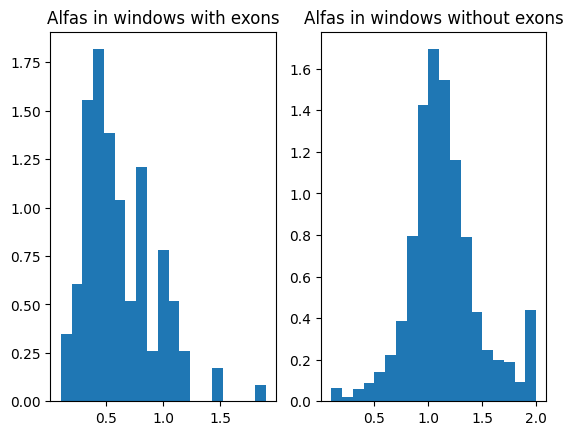

In [35]:
fig, ax = plt.subplots(1,2)

ax[1].hist(alfas_without_exons, bins=19, density=True, label="Alfas without exons")
ax[0].hist(alfas_with_exons, bins=19, density=True, label="Alfas with exons")
ax[1].set_title("Alfas in windows without exons")
ax[0].set_title("Alfas in windows with exons")
fig.savefig("exons_non_exons_comp.png")
fig.show

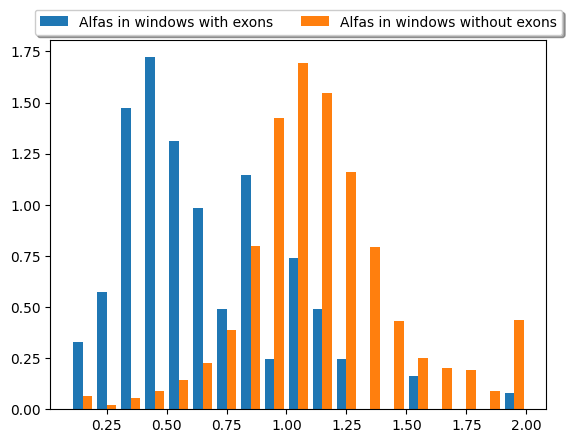

In [39]:
plt.hist([alfas_with_exons, alfas_without_exons], bins=19, density=True, label=["Alfas in windows with exons", "Alfas in windows without exons"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.savefig("exons_non_exons_comb.png")